In [1]:
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy import stats
from config import config_dict
import os
import neurodsp
import glob

from operator import itemgetter
from itertools import groupby
import statsmodels.formula.api as smf
import matplotlib.mlab as mlab

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('Cole_2018.mplstyle')

pd.options.display.max_columns=100

In [2]:
# Make directory for saving figures
if not os.path.exists('figs/5'):
    os.makedirs('figs/5')

# Load data

In [3]:
burst_type = 0
sync_ms = config_dict['analysis_synchrony_ms']

df_shanks = pd.read_csv(config_dict['processed_path'] + 'df_shanks_stats.csv', index_col=0)
df_shanks = df_shanks[df_shanks['burst_type']==burst_type].reset_index()
df_shanks.head()

,index,rat,sess,sh,Fs,elec,burst_type,amp_mean,period_mean,rdsym_mean,ptsym_mean,cycling_frac,N_cycles_all,N_cycles_burst,N_seconds,corr_volt_amp_period_r,corr_volt_amp_period_p,corr_volt_amp_time_rdsym_r,corr_volt_amp_time_rdsym_p,corr_volt_amp_time_ptsym_r,corr_volt_amp_time_ptsym_p,corr_period_time_rdsym_r,corr_period_time_rdsym_p,corr_period_time_ptsym_r,corr_period_time_ptsym_p,corr_time_rdsym_time_ptsym_r,corr_time_rdsym_time_ptsym_p,mv_amp_mean,ms_period_mean
0,0,ec013,ec013.426,4,1250,0,0,2319.532520,161.287866,0.412290,0.414131,0.785563,11644,9362,1537.7272,-0.077456,6.156500e-14,0.040812,7.814688e-05,-0.056677,4.075107e-08,-0.078357,3.143550e-14,0.068883,2.523349e-11,-0.069632,1.533282e-11,2.319533,129.030293
1,4,ec013,ec013.426,5,1250,0,0,2200.710141,161.099577,0.412755,0.419072,0.773503,11619,9229,1537.7200,-0.068670,4.006313e-11,0.062534,1.825662e-09,-0.043223,3.271105e-05,-0.082509,2.039848e-15,0.070847,9.510113e-12,-0.067264,9.909330e-11,2.200710,128.879662
2,8,ec013,ec013.426,6,1250,0,0,1672.178699,161.369480,0.411551,0.448304,0.809731,11680,9646,1537.8640,0.018115,7.523005e-02,0.034804,6.287863e-04,-0.031303,2.106493e-03,-0.010428,3.058098e-01,0.058119,1.115245e-08,-0.090853,3.877569e-19,1.672179,129.095584
3,12,ec013,ec013.426,7,1250,0,0,1693.289664,161.321549,0.415398,0.475218,0.819043,11706,9759,1537.7336,0.010477,3.007297e-01,-0.052982,1.632134e-07,0.057119,1.636914e-08,0.045350,7.401943e-06,0.090220,4.271117e-19,-0.125847,9.571640e-36,1.693290,129.057239
4,16,ec013,ec013.482,4,1250,0,0,1919.829110,166.277068,0.403384,0.438942,0.803501,15953,13069,2163.6064,-0.008160,3.509288e-01,0.024827,4.534006e-03,-0.048778,2.418237e-08,-0.025403,3.680641e-03,0.057749,3.929036e-11,-0.051819,3.078324e-09,1.919829,133.021654


In [4]:
df_neus = pd.read_csv(config_dict['processed_path'] + 'df_neus_stats.csv', index_col=0)
df_neus = df_neus[df_neus['N_spikes_burst' + str(burst_type)] >= config_dict['analysis_N_spikes_min']]
df_neus.head()

,rat,sess,sh,clu,fr1,fr2,type,fr_recording,N_spikes_recording,fr_burst0,fr_notburst0,N_spikes_burst0,mwu_fr_burst0_notburst_p,fr_burst1,fr_notburst1,N_spikes_burst1,mwu_fr_burst1_notburst_p,fr_burst2,fr_notburst2,N_spikes_burst2,mwu_fr_burst2_notburst_p,fr_burst3,fr_notburst3,N_spikes_burst3,mwu_fr_burst3_notburst_p,sfc_magnitude_recording,sfc_phase_recording,sfc_magnitude_cycles,sfc_phase_cycles,sfc_magnitude_cycles_hilbert,sfc_phase_cycles_hilbert,norm_fr_diff_burst0,norm_fr_diff_burst1,norm_fr_diff_burst2,norm_fr_diff_burst3,sfc_phase_cycles_2pi
0,ec013,ec013.426,4,2,0.407231,0.512286,p,0.335560,516,0.342720,0.309329,414,0.297142,0.465436,0.296954,164,0.000241,0.341970,0.296940,451,0.206365,0.402520,0.331910,32,0.324259,0.318662,-2.128263,0.304635,-1.975268,0.348779,-1.898694,0.051209,0.220992,0.070479,0.096143,4.307917
1,ec013,ec013.426,4,3,0.353281,0.352440,p,0.434407,668,0.432954,0.439733,523,0.194954,0.451246,0.429402,159,0.429642,0.431444,0.452263,569,0.152204,0.628937,0.423802,50,0.017322,0.215493,-1.255455,0.249578,-1.076320,0.290599,-1.131971,-0.007768,0.024805,-0.023559,0.194858,5.206865
2,ec013,ec013.426,4,4,0.109063,0.108744,n,0.138516,213,0.144042,0.118273,174,0.323910,0.164606,0.130761,58,0.157852,0.142551,0.114208,188,0.305673,0.264154,0.131667,21,0.001572,0.254388,-2.890571,0.281561,-2.835208,0.270133,-2.699108,0.098237,0.114585,0.110388,0.334715,3.447977
4,ec013,ec013.426,4,6,0.171849,0.173298,p,0.368726,567,0.350171,0.436700,423,0.004107,0.289479,0.392283,102,0.009864,0.369267,0.365465,487,0.378360,0.352205,0.369627,28,0.235159,0.158567,-1.042183,0.193546,-0.940314,0.224406,-1.033804,-0.109966,-0.150792,0.005175,-0.024136,5.342871
5,ec013,ec013.426,4,7,0.114460,0.114488,n,0.137866,212,0.153148,0.081881,185,0.004540,0.133387,0.139197,47,0.374909,0.148617,0.073093,196,0.006614,0.100630,0.139896,8,0.158331,0.360161,3.010637,0.382187,3.020894,0.323802,3.105076,0.303225,-0.021314,0.340643,-0.163250,3.020894


In [5]:
df_burst_stats = pd.read_csv(config_dict['processed_path'] + 'df_burst_stats.csv', index_col=0)
df_burst_stats = df_burst_stats[df_burst_stats['burst_type']==0]
df_burst_stats.head()

,rat,sess,sh,burst_type,N_bursts,mv_amp_adjburst_r,mv_amp_adjburst_p,ms_period_adjburst_r,ms_period_adjburst_p,time_rdsym_adjburst_r,time_rdsym_adjburst_p,time_ptsym_adjburst_r,time_ptsym_adjburst_p,speed_adjburst_r,speed_adjburst_p,mv_amp_first_coef,mv_amp_first_p,ms_period_first_coef,ms_period_first_p,time_rdsym_first_coef,time_rdsym_first_p,time_ptsym_first_coef,time_ptsym_first_p,glm_first_r2,mv_amp_first_speed_coef,mv_amp_first_speed_p,ms_period_first_speed_coef,ms_period_first_speed_p,time_rdsym_first_speed_coef,time_rdsym_first_speed_p,time_ptsym_first_speed_coef,time_ptsym_first_speed_p,speed_first_speed_coef,speed_first_speed_p,glm_first_speed_r2
0,ec013,ec013.426,4,0,560,0.280468,0.017018,-0.085425,0.475553,0.290726,0.013231,0.272654,0.020496,NaN,NaN,4.107549,0.014071,-2.208481,0.166422,-0.806805,0.609669,-1.897287,0.257887,0.091743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ec013,ec013.426,5,0,572,0.195690,0.085974,0.180480,0.113824,0.123585,0.281037,0.161547,0.157652,NaN,NaN,2.286813,0.093028,-1.236609,0.357191,-1.669178,0.245931,-1.816564,0.212477,0.055507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ec013,ec013.426,6,0,555,0.268695,0.026722,0.057699,0.640240,0.241516,0.047239,0.151888,0.216286,NaN,NaN,3.156491,0.015892,2.217724,0.087359,-1.262222,0.332206,0.846999,0.518588,0.146575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,ec013,ec013.426,7,0,567,0.305532,0.015741,-0.111710,0.387361,0.213165,0.096215,0.090479,0.484322,NaN,NaN,1.357833,0.484857,-2.560282,0.192314,-2.668952,0.226361,-0.094681,0.965968,0.067317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,ec013,ec013.482,4,0,708,0.374605,0.000034,0.071576,0.445147,0.069550,0.458171,0.148433,0.111793,NaN,NaN,2.419422,0.042606,-2.421446,0.038836,-1.548473,0.189234,-0.621203,0.606867,0.071985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
burst_len_distributions = np.load(config_dict['processed_path'] + 'burst0_lengths.npy')

# A. Distribution of burst durations

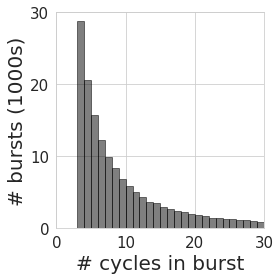

In [7]:
# Distribution of number of cycles in a burst
plt.figure(figsize=(4,4))
plt.hist(burst_len_distributions, bins=np.arange(40),
         edgecolor='black', color='k', alpha=.5,
         weights=np.ones_like(burst_len_distributions)/1000)
    
plt.xticks(np.arange(0,31,10))
plt.xlim((0,30))
plt.yticks(np.arange(0, 31, 10))
plt.ylim((0, 30))
plt.ylabel('# bursts (1000s)')
plt.xlabel('# cycles in burst')
plt.tight_layout()
plt.savefig('figs/5/A.png')

# B. Correlation between burst duration and first cycle features

/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


mv_amp p = 7E-08, W = 2886, N = 152, Average GLM coef = 0.673
ms_period p = 6E-17, W = 1262, N = 152, Average GLM coef = -0.777
time_rdsym p = 1E-07, W = 2924, N = 152, Average GLM coef = -0.331
time_ptsym p = 2E-06, W = 3250, N = 152, Average GLM coef = -0.328


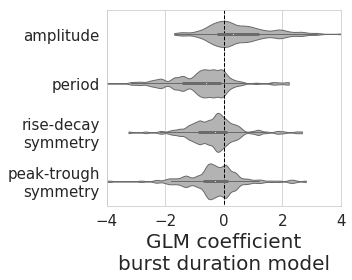

In [8]:
# All features
feats = ['mv_amp', 'ms_period', 'time_rdsym', 'time_ptsym']
feat_names = {'mv_amp': 'amplitude', 'ms_period': 'period',
              'time_rdsym': 'rise-decay\nsymmetry', 'time_ptsym': 'peak-trough\nsymmetry'}

plt.figure(figsize=(5, 4))
plt.plot([0,0], [-10,10], 'k--')
df_plt = df_burst_stats[[feat+'_first_coef' for feat in feats]].stack().reset_index().rename(
         columns={'level_1': 'feature', 0: 'glm_coef'}).replace(
         {k+'_first_coef':feat_names[k] for k in feats})
sns.violinplot(x='glm_coef', y='feature', data=df_plt,
               cut=0, split=True, width=.8, gridsize=100, bw=.1, color='.7')
# sns.stripplot(x='glm_coef', y='feature', data=df_plt)
plt.xlabel('GLM coefficient\nburst duration model')
plt.xlim((-4, 4))
plt.ylabel('')
plt.tight_layout()
plt.savefig('figs/5/B.png')

# Print stats
for feat in feats:
    W, p = stats.wilcoxon(df_burst_stats[feat+'_first_coef'])
    print(feat, 'p = {:.0E}, W = {:.0f}, N = {:d}, Average GLM coef = {:.3f}'.format(p, W, len(df_burst_stats[feat+'_first_coef']),
                                                                         df_burst_stats[feat+'_first_coef'].mean()))


Mean R^2: 0.049


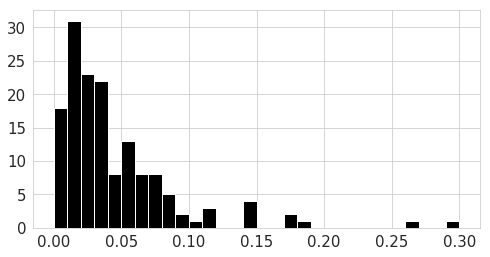

In [9]:
plt.figure(figsize=(8,4))
plt.hist(df_burst_stats['glm_first_r2'], bins=np.arange(0,.31, .01), color='k')
print('Mean R^2: {:.3f}'.format(df_burst_stats['glm_first_r2'].mean()))

### GLM model including speed

In [10]:
# Print stats
for feat in feats:
    W, p = stats.wilcoxon(df_burst_stats[feat+'_first_speed_coef'].dropna())
    print(feat, 'p = {:.0E}, W = {:.0f}, N = {:d}, Average GLM coef = {:.3f}'.format(p, W, len(df_burst_stats[feat+'_first_speed_coef'].dropna()),
                                                                         df_burst_stats[feat+'_first_speed_coef'].dropna().mean()))

mv_amp p = 7E-04, W = 109, N = 35, Average GLM coef = 1.231
ms_period p = 1E-04, W = 80, N = 35, Average GLM coef = -0.932
time_rdsym p = 4E-02, W = 188, N = 35, Average GLM coef = -0.268
time_ptsym p = 2E-04, W = 85, N = 35, Average GLM coef = -0.738


# C. Correlation between adjacent burst features, all recordings

mv_amp p = 1E-22, Average rho = 0.160
ms_period p = 1E-21, Average rho = 0.112
time_rdsym p = 2E-12, Average rho = 0.058
time_ptsym p = 6E-19, Average rho = 0.092


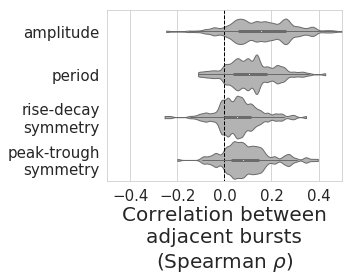

In [11]:
# All features
feats = ['mv_amp', 'ms_period', 'time_rdsym', 'time_ptsym']
feat_names = {'mv_amp': 'amplitude', 'ms_period': 'period',
              'time_rdsym': 'rise-decay\nsymmetry', 'time_ptsym': 'peak-trough\nsymmetry'}

plt.figure(figsize=(5, 4))
plt.plot([0,0], [-10,10], 'k--')
df_plt = df_burst_stats[[feat+'_adjburst_r' for feat in feats]].stack().reset_index().rename(
         columns={'level_1': 'feature', 0: 'rho'}).replace(
         {k+'_adjburst_r':feat_names[k] for k in feats})
sns.violinplot(x='rho', y='feature', data=df_plt,
               cut=0, split=True, width=1, gridsize=100, bw=.1, color='.7')
plt.xlabel('Correlation between\nadjacent bursts\n(Spearman $\\rho$)')
plt.ylabel('')
plt.xlim((-.5, .5))

plt.tight_layout()
plt.savefig('figs/5/C.png')

# Print stats
for feat in feats:
    W, p = stats.wilcoxon(df_burst_stats[feat+'_adjburst_r'])
    print(feat, 'p = {:.0E}, Average rho = {:.3f}'.format(p, df_burst_stats[feat+'_adjburst_r'].mean()))

In [12]:
print('% recordings without a positive correlation between adjacent burst features')
for feat in feats:
    rows_keep = np.logical_or(df_burst_stats[feat+'_adjburst_p'] > 0.5,
                              df_burst_stats[feat+'_adjburst_r'] < 0)
    print('{:s}: {:.0f}% recordings'.format(feat, 100*np.mean(rows_keep)))


% recordings without a positive correlation between adjacent burst features
mv_amp: 22% recordings
ms_period: 30% recordings
time_rdsym: 47% recordings
time_ptsym: 36% recordings


# D-E. Difference in firing rate between theta and nontheta

p, p= 6E-37, N = 760, W=67682, mean norm. change in FR = 0.111
i, p= 2E-15, N = 119, W=569, mean norm. change in FR = 0.149


/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  app.launch_new_instance()
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  app.launch_new_instance()


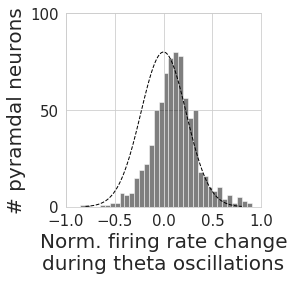

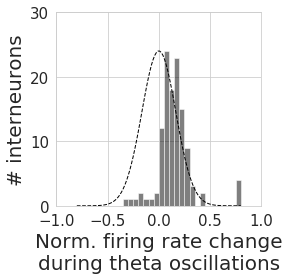

In [13]:
for neutype, neuname, letter, yticks in zip(
    ['p', 'i'], ['pyramdal ', 'inter'], ['D', 'E'],
    [np.arange(0, 101, 50), np.arange(0, 31, 10)]):
    
    df_temp = df_neus[df_neus['type']==neutype]
    W, p = stats.wilcoxon(df_temp['norm_fr_diff_burst' + str(burst_type)])
    print('{:s}, p= {:.0E}, N = {:d}, W={:.0f}, mean norm. change in FR = {:.3f}'.format(neutype, p, len(df_temp), W,
                                                  df_temp['norm_fr_diff_burst' + str(burst_type)].mean()))
    
    plt.figure(figsize=(4, 4))
    plt.hist(df_neus[df_neus['type']==neutype]['norm_fr_diff_burst' + str(burst_type)],
             bins=np.arange(-1, 1.05, .05), color='k', alpha=.5)
    
    # Plot null Gaussian
    x_gauss = np.linspace(-.8,.8, 100)
    y_gauss = mlab.normpdf(x_gauss, 0, np.std(df_neus[df_neus['type']==neutype]['norm_fr_diff_burst' + str(burst_type)]))
    y_gauss = y_gauss * yticks[-1]*.8 / np.max(y_gauss)
    plt.plot(x_gauss, y_gauss, 'k--')
    
    plt.xlabel('Norm. firing rate change\nduring theta oscillations')
    plt.ylabel('# {:s}neurons'.format(neuname))
    plt.yticks(yticks)
    plt.xticks(np.arange(-1,1.1,.5))
    plt.xlim((-1,1))
    plt.ylim((yticks[0], yticks[-1]))

    plt.tight_layout()
    plt.savefig('figs/5/{:s}.png'.format(letter))

# F-G. Neuron synchrony and theta presence

### Make neuron pair df

In [14]:
df_neu_pairs = pd.read_csv(config_dict['processed_path'] + 'df_neuron_pairs.csv', index_col=0)
df_neu_pairs = df_neu_pairs[df_neu_pairs['burst_type'] == burst_type]
df_neu_pairs = df_neu_pairs[df_neu_pairs['synchrony_ms'] == sync_ms].reset_index()

df_neus_cols = ['rat', 'sess', 'sh', 'clu', 'fr_burst' + str(burst_type), 'sfc_magnitude_cycles', 'sfc_phase_cycles', 'type']
df_neu_pairs = df_neu_pairs.merge(df_neus[df_neus_cols], left_on = ['rat', 'sess', 'sh', 'clu1'], right_on= ['rat', 'sess', 'sh', 'clu'])
df_neu_pairs = df_neu_pairs.rename({'fr_cycles': 'clu1_fr',
                                    'sfc_magnitude_cycles': 'clu1_sfc_mag',
                                    'sfc_phase_cycles': 'clu1_sfc_pha',
                                    'type': 'clu1_type'}, axis=1)
df_neu_pairs = df_neu_pairs.drop('clu', axis=1)
df_neu_pairs = df_neu_pairs.merge(df_neus[df_neus_cols], left_on = ['rat', 'sess', 'sh', 'clu2'], right_on= ['rat', 'sess', 'sh', 'clu'])
df_neu_pairs = df_neu_pairs.rename({'fr_cycles': 'clu2_fr',
                                    'sfc_magnitude_cycles': 'clu2_sfc_mag',
                                    'sfc_phase_cycles': 'clu2_sfc_pha',
                                    'type': 'clu2_type'}, axis=1)
df_neu_pairs = df_neu_pairs.drop('clu', axis=1)

### add features for sfc similarity between units

In [15]:
# Define hyperparameters of analysis
ms = config_dict['analysis_synchrony_ms']
time_scale = str(ms) + 'ms'
min_N_spikes = config_dict['analysis_N_spikes_min']
min_N_sync_spikes = config_dict['analysis_N_sync_min']
min_N_spikes_percat = config_dict['analysis_N_spikes_min_percat']

In [16]:
# Compute difference in sync between burst and not burst
df_neu_pairs['is_burst_sync_diff'] = (df_neu_pairs['is_burst_sync_mean'] - \
                                                 df_neu_pairs['is_burst_nonsync_mean']) / df_neu_pairs['is_burst_nonsync_mean']

### Plot synchrony difference

# neuron pairs = 496
p, W = 23829, p = 2.6E-32, A synchrony event increases probability of theta by -0.07
# neuron pairs = 45
i, W = 43, p = 8.5E-08, A synchrony event increases probability of theta by 0.09


/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


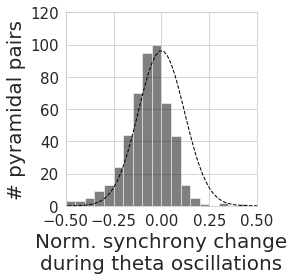

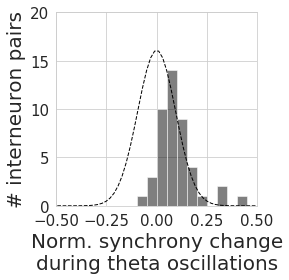

In [17]:
for neutype, name, letter, yticks in zip(['p', 'i'], ['pyramidal', 'interneuron'], ['F', 'G'],
                                         [np.arange(0, 121, 20), np.arange(0, 21, 5)]):
    df_temp = df_neu_pairs[(df_neu_pairs['clu1_type']==neutype) &
                           (df_neu_pairs['clu2_type']==neutype)]
    # Require minimum number of spikes
    df_temp = df_temp[df_temp['N_sync_spikes_recording']>=min_N_sync_spikes]
    df_temp = df_temp[df_temp['N_is_burst_sync']>=min_N_spikes_percat]
    df_temp = df_temp[df_temp['N_is_nonburst_sync']>=min_N_spikes_percat]
    df_temp = df_temp[df_temp['N_is_burst_nonsync']>=min_N_spikes_percat]
    df_temp = df_temp[df_temp['N_is_nonburst_nonsync']>=min_N_spikes_percat]
    
    # Number of each neuron for analysis
    print('# neuron pairs =', len(df_temp))
    
    W, p = stats.wilcoxon(df_temp['is_burst_sync_diff'])
    print(neutype+', W = {:.0f}, p = {:5.1E}, A synchrony event increases probability of theta by {:.2f}'.format(W, p, df_temp['is_burst_sync_diff'].mean()))

    fig = plt.figure(figsize=(4,4))
    plt.hist(df_temp['is_burst_sync_diff'],
             bins=np.arange(-1, 1, .05), color='k', alpha=.5)
    
    # Plot null Gaussian
    x_gauss = np.linspace(-1, 1, 100)
    y_gauss = mlab.normpdf(x_gauss, 0, np.std(df_temp['is_burst_sync_diff']))
    y_gauss = y_gauss * yticks[-1]*.8 / np.max(y_gauss)
    plt.plot(x_gauss, y_gauss, 'k--')
    
    plt.xticks(np.arange(-.5, .6, .25))
    plt.xlim((-.5, .5))
    plt.yticks(yticks)
    plt.ylim((yticks[0], yticks[-1]))
    plt.xlabel('Norm. synchrony change\nduring theta oscillations')
    plt.ylabel('# {:s} pairs'.format(name))
    plt.tight_layout()
    
    extent = plt.gca().get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig('figs/5/{:s}.png'.format(letter), bbox_inches=extent.expanded(1.8, 1.8))

# H-I. Neither PY nor IN cells have more consistent sequence during theta

In [18]:
df_neu_pairs_raw = pd.read_csv(config_dict['processed_path'] + 'df_neuron_pairs.csv', index_col=0)
df_neu_pairs_raw = df_neu_pairs_raw[df_neu_pairs_raw['burst_type']==burst_type]

df_neus_cols = ['rat', 'sess', 'sh', 'clu',
                'sfc_magnitude_cycles', 'sfc_phase_cycles', 'type']

df_neu_pairs_raw = df_neu_pairs_raw.merge(df_neus[df_neus_cols],
                                  left_on = ['rat', 'sess', 'sh', 'clu1'],
                                  right_on = ['rat', 'sess', 'sh', 'clu'])
df_neu_pairs_raw = df_neu_pairs_raw.rename({'fr_cycles': 'clu1_fr',
                                    'sfc_magnitude_cycles': 'clu1_sfc_mag',
                                    'sfc_phase_cycles': 'clu1_sfc_pha',
                                    'type': 'clu1_type'}, axis=1)
df_neu_pairs_raw = df_neu_pairs_raw.drop('clu', axis=1)
df_neu_pairs_raw = df_neu_pairs_raw.merge(df_neus[df_neus_cols], left_on = ['rat', 'sess', 'sh', 'clu2'], right_on= ['rat', 'sess', 'sh', 'clu'])
df_neu_pairs_raw = df_neu_pairs_raw.rename({'fr_cycles': 'clu2_fr',
                                    'sfc_magnitude_cycles': 'clu2_sfc_mag',
                                    'sfc_phase_cycles': 'clu2_sfc_pha',
                                    'type': 'clu2_type'}, axis=1)
df_neu_pairs_raw = df_neu_pairs_raw.drop('clu', axis=1)

# Add Fs to neu pairs
df_neu_pairs_raw = df_neu_pairs_raw.merge(df_shanks[['rat','sess','sh','Fs']],
                                  on=['rat','sess','sh'], how='left')

In [19]:
neu_types = ['p', 'i']
names = {'p': 'pyramidal', 'i': 'interneuron'}
twindows = np.arange(10, 51, 10)
feats = ['volt_amp', 'period', 'time_rdsym', 'time_ptsym']

dict_sig = defaultdict(list)
for neu_type in neu_types:
    df_type = df_neu_pairs_raw[(df_neu_pairs_raw['clu1_type']==neu_type) &
                               (df_neu_pairs_raw['clu2_type']==neu_type)]
    for twindow in twindows:
        df_temp = df_type[df_type['synchrony_ms']==twindow]
        df_temp = df_temp.replace([np.inf, 0], np.nan).dropna(subset=['preoverpost_frac_theta',
                                                                      'preoverpost_frac_nottheta'])
        df_temp = df_temp[df_temp['N_spikes_sequence']>=min_N_sync_spikes]
        df_temp = df_temp[df_temp['N_is_burst_pre']>=min_N_spikes_percat]
        df_temp = df_temp[df_temp['N_is_nonburst_pre']>=min_N_spikes_percat]
        df_temp = df_temp[df_temp['N_is_burst_post']>=min_N_spikes_percat]
        df_temp = df_temp[df_temp['N_is_nonburst_post']>=min_N_spikes_percat]
        
        # Make figure comparing sequence ratio for theta vs. nontheta
        seqratio_theta = [xi if xi > 1 else 1/xi for xi in df_temp['preoverpost_frac_theta']]
        seqratio_nottheta = [xi if xi > 1 else 1/xi for xi in df_temp['preoverpost_frac_nottheta']]
        
        # Compute stats
        W, p = stats.wilcoxon(seqratio_theta, seqratio_nottheta)
        seq_diffs = np.array(seqratio_theta) - np.array(seqratio_nottheta)
        print('{:s}, {:d}ms, Average sequence ratio difference = {:.2f}, W = {:.0f}, p = {:.2f}, N={:d}'.format(neu_type, twindow, np.mean(seq_diffs), W, p, len(seq_diffs)))

p, 10ms, Average sequence ratio difference = 0.02, W = 1314, p = 0.69, N=74
p, 20ms, Average sequence ratio difference = -0.00, W = 4188, p = 0.55, N=133
p, 30ms, Average sequence ratio difference = -0.02, W = 6607, p = 0.20, N=172
p, 40ms, Average sequence ratio difference = -0.03, W = 9491, p = 0.17, N=206
p, 50ms, Average sequence ratio difference = -0.04, W = 11169, p = 0.04, N=231
i, 10ms, Average sequence ratio difference = 0.02, W = 394, p = 0.64, N=41
i, 20ms, Average sequence ratio difference = 0.03, W = 487, p = 0.93, N=44
i, 30ms, Average sequence ratio difference = 0.08, W = 374, p = 0.63, N=40
i, 40ms, Average sequence ratio difference = 0.12, W = 362, p = 0.26, N=42
i, 50ms, Average sequence ratio difference = 0.15, W = 329, p = 0.19, N=41


p, Average sequence ratio difference = -0.00, W = 4188,p = 0.548, N=133
i, Average sequence ratio difference = 0.03, W = 487,p = 0.926, N=44


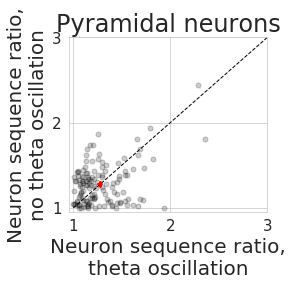

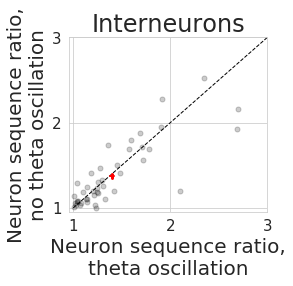

In [20]:
for neu_type, name, letter in zip(['p', 'i'], ['Pyramidal ', 'Inter'], ['H', 'I']):
    # Prepare table for analysis
    df_temp = df_neu_pairs[(df_neu_pairs['clu1_type']==neu_type) &
                           (df_neu_pairs['clu2_type']==neu_type)]
    df_temp = df_temp.replace([np.inf, 0], np.nan).dropna(subset=['preoverpost_frac_theta',
                                                                  'preoverpost_frac_nottheta'])
    df_temp = df_temp[df_temp['N_spikes_sequence']>=min_N_sync_spikes]
    df_temp = df_temp[df_temp['N_is_burst_pre']>=min_N_spikes_percat]
    df_temp = df_temp[df_temp['N_is_nonburst_pre']>=min_N_spikes_percat]
    df_temp = df_temp[df_temp['N_is_burst_post']>=min_N_spikes_percat]
    df_temp = df_temp[df_temp['N_is_nonburst_post']>=min_N_spikes_percat]

    # Make figure comparing sequence ratio for theta vs. nontheta
    seqratio_theta = np.array([xi if xi > 1 else 1/xi for xi in df_temp['preoverpost_frac_theta']])
    seqratio_nottheta = np.array([xi if xi > 1 else 1/xi for xi in df_temp['preoverpost_frac_nottheta']])
    plt.figure(figsize=(4,4))
    plt.plot(10**(seqratio_theta), 10**(seqratio_nottheta), 'k.', alpha=.2)
    plt.plot([10, 1000], [10, 1000], 'k--')
    
    # Make crosshare for average
    cross_theta = {'mean': np.mean(seqratio_theta), 'sem': stats.sem(seqratio_theta)}
    cross_nottheta = {'mean': np.mean(seqratio_nottheta), 'sem': stats.sem(seqratio_nottheta)}
    plt.plot([10**(cross_theta['mean']), 10**(cross_theta['mean'])],
             [10**(cross_nottheta['mean']) - 10**(cross_nottheta['sem']),
              10**(cross_nottheta['mean']) + 10**(cross_nottheta['sem'])],
             'r-', linewidth=3)
    plt.plot([10**(cross_theta['mean']) - 10**(cross_theta['sem']),
              10**(cross_theta['mean']) + 10**(cross_theta['sem'])], 
             [10**(cross_nottheta['mean']), 10**(cross_nottheta['mean'])],
             'r-', linewidth=2)
    
    # Format figure
    plt.xlim((9, 1000))
    plt.ylim((9, 1000))
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks([10, 100, 1000],['1','2','3'])
    plt.yticks([10, 100, 1000],['1','2','3'])

    plt.xlabel('Neuron sequence ratio,\ntheta oscillation')
    plt.ylabel('Neuron sequence ratio,\nno theta oscillation')
    plt.title('{:s}neurons'.format(name))
    plt.tight_layout()
    plt.savefig('figs/5/{:s}.png'.format(letter))

    # Compute stats
    W, p = stats.wilcoxon(seqratio_theta, seqratio_nottheta)
    seq_diffs = np.array(seqratio_theta) - np.array(seqratio_nottheta)
    print('{:s}, Average sequence ratio difference = {:.2f}, W = {:.0f},p = {:.3f}, N={:d}'.format(neu_type, np.mean(seq_diffs), W, p, len(seq_diffs)))
    